In [15]:
%matplotlib inline
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise, bpp

# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [16]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

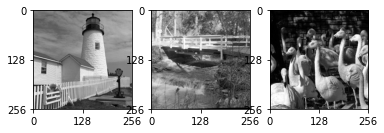

In [17]:
fig, axs = plt.subplots(1, 3)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])

Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

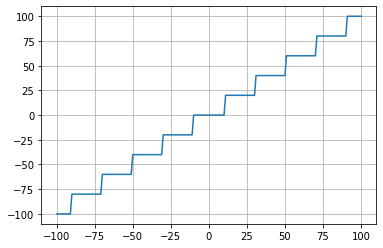

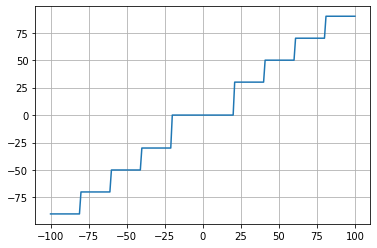

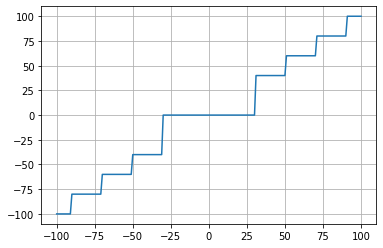

In [18]:
# your code here
for rise1 in [0.5,1.0,1.5]:
    x = np.arange(-100, 100+1)
    y = quantise(x, 20, rise1*20)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()

A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

In [19]:
# you may wish to work in standalone python files at this point!
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import colxfm, regroup

C8 = dct_ii(8)

def dctbpp(Yr, N):
    Yq_s = Yr

    total_bits = 0
    l = int(256/N)
    for i in np.arange(0,256,l):

        
        for j in np.arange(0,256,l):
            subimage = Yr[i:i+l,j:j+l]
            bits_sub = bpp(subimage)*l*l
            total_bits += bits_sub

    return total_bits

def DCT_error(image, step,Y,C, rise1):

    Yq = quantise(Y,step, rise1)
    #Yr = regroup(Yq,8)/8
    Zq = colxfm(colxfm(Yq.T, C.T).T, C.T)
    error = np.std(image-Zq)

    return error

X = lighthouse
threshold = np.std(X-quantise(X,17))
epsilon = 0.01

def gradient_dec(image, threshold, epsilon, N, step, rise1Factor):
    C = dct_ii(N)
    Y = colxfm(colxfm(image, C).T, C).T
    f_k1 = DCT_error(image, step,Y,C, rise1Factor*step)

    while f_k1>threshold:

        backward_step = DCT_error(image, step - epsilon,Y,C, rise1Factor*(step-epsilon))
        forward_step = DCT_error(image, step + epsilon,Y,C, rise1Factor*(step+epsilon))
        if backward_step < forward_step:
            new_step = step - epsilon
            f_k1 = backward_step
        elif backward_step > forward_step:
            new_step = step - epsilon
            f_k1 = forward_step

        step = new_step

    return f_k1,new_step

def c_ratio(image,N,step, rise1):
    reference_scheme = bpp(quantise(image,17))*256*256
    C = dct_ii(N)
    Y = colxfm(colxfm(image, C).T, C).T
    Yq = quantise(Y,step, rise1)
    Yr = regroup(Yq,N)/N
    Zq = colxfm(colxfm(Yq.T, C.T).T, C.T)
    compressed_scheme = dctbpp(Yr,N)
    return (reference_scheme/compressed_scheme), compressed_scheme, Zq

4.924698773259525 24.10000000000148
(2.9870423558535046,)
4.92274496464852 15.600000000001366
(3.1963331775966823,)
4.899004666161848 10.900000000001382
(3.09039966357316,)
4.931212291893125 8.400000000001391
(3.0087775902705736,)


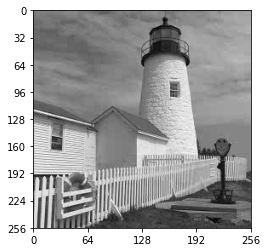

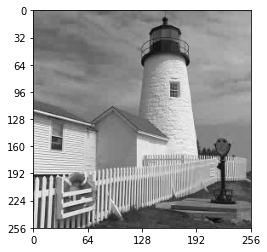

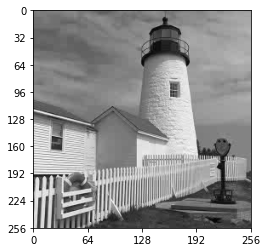

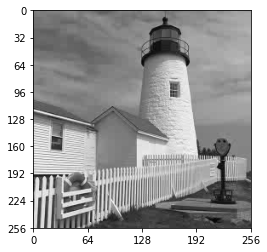

In [20]:
threshold = np.std(X-quantise(X,17))
epsilon = 0.1

for i in [0.5, 1, 1.5, 2]:
    f_k1 , new_step = gradient_dec(X, threshold,epsilon,8, 100, i)

    print(f_k1,new_step)

    Y = colxfm(colxfm(X, C8).T, C8).T
    Yq = quantise(Y,new_step, new_step*i)

    Zq = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    fig,ax = plt.subplots()
    plot_image(Zq,ax=ax)
    

    print(c_ratio(lighthouse, 8, new_step, new_step*i)[:1])

4.871298951006253 19.700000000001417
(2.208384310757931,)
4.873699876866749 12.900000000001375
(2.298062058251737,)
4.883523187794231 9.100000000001389
(2.2088301716889847,)
4.843849558294945 6.900000000001397
(2.2117077036511836,)


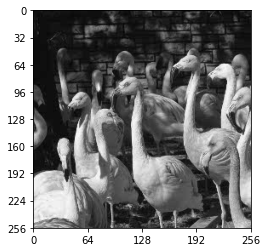

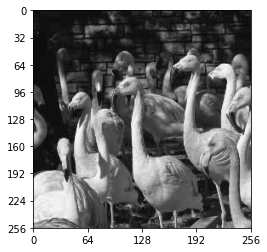

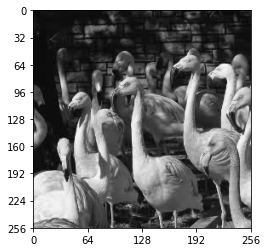

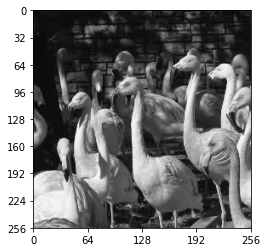

In [21]:
threshold = np.std(flamingo-quantise(flamingo,17))
epsilon = 0.1

for i in [0.5, 1, 1.5, 2]:
    f_k1 , new_step = gradient_dec(flamingo, threshold,epsilon,8, 100, i)

    print(f_k1,new_step)

    Y = colxfm(colxfm(flamingo, C8).T, C8).T
    Yq = quantise(Y,new_step, new_step*i)

    Zq = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    fig,ax = plt.subplots()
    plot_image(Zq,ax=ax)
    
    #info = c_ratio(lighthouse, )
    print(c_ratio(flamingo, 8, new_step, new_step*i)[:1])

4.861591150285653 17.70000000000139
(1.8438913278989029,)
4.858277488544133 11.50000000000138
(1.8630515227244322,)
4.875217575127481 8.100000000001392
(1.7692247726234411,)
4.808067586880086 6.100000000001399
(1.7135860727762373,)


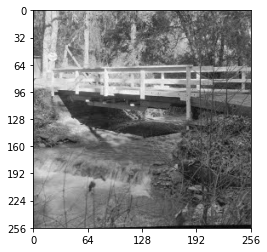

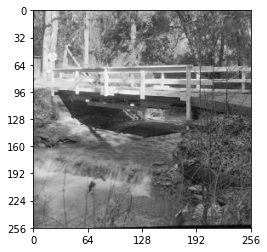

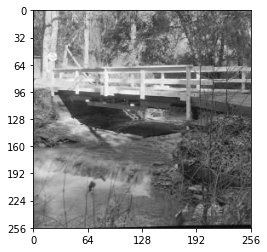

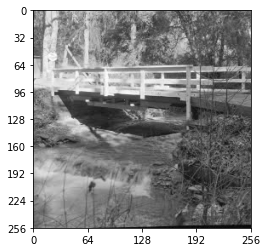

In [22]:
threshold = np.std(bridge-quantise(bridge,17))
epsilon = 0.1

for i in [0.5, 1, 1.5, 2]:
    f_k1 , new_step = gradient_dec(bridge, threshold,epsilon,8, 100, i)

    print(f_k1,new_step)

    Y = colxfm(colxfm(bridge, C8).T, C8).T
    Yq = quantise(Y,new_step, new_step*i)

    Zq = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    fig,ax = plt.subplots()
    plot_image(Zq,ax=ax)

    print(c_ratio(bridge, 8, new_step, new_step*i)[:1])

In [23]:
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray, RiseFactor):
    """
    Parameters:
        Y: the output of `dwt(X, n)`
        dwtstep: an array of shape `(3, n+1)`
    Returns:
        Yq: the quantized version of `Y`
        dwtenc: an array of shape `(3, n+1)` containing the entropies
    """
    # your code here
    n = np.shape(dwtstep)[1] 
    # print(n)
    m = 256
    dwtbits = np.empty((3,n))
    dwtents = np.empty((3,n))
    Yq = np.zeros((256,256))
    
    for i in range(n-1):
        m = m//2
        
        Y00 = quantise(Y[m:2*m,:m], dwtstep[0,i], dwtstep[0,i]*RiseFactor)
        Y10 = quantise(Y[m:2*m,m:2*m], dwtstep[1,i], dwtstep[1,i]*RiseFactor)
        Y20 = quantise(Y[:m,m:2*m], dwtstep[2,i], dwtstep[2,i]*RiseFactor)
        
        EY00 = bpp(Y00)*m*m
        EY10 = bpp(Y10)*m*m
        EY20 = bpp(Y20)*m*m
        
        EY00_e = bpp(Y00)
        EY10_e = bpp(Y10)
        EY20_e = bpp(Y20)

        dwtents[0][i] = EY00
        dwtents[1][i] = EY10
        dwtents[2][i] = EY20
        
        dwtbits[0][i] = EY00_e
        dwtbits[1][i] = EY10_e
        dwtbits[2][i] = EY20_e

        Yq[m:2*m,:m] = Y00
        Yq[m:2*m,m:2*m] = Y10
        Yq[:m,m:2*m] = Y20
        
    # m = m//2
    
    Y03 = quantise(Y[:m,:m], dwtstep[0,0], dwtstep[0,0]*RiseFactor)
    Yq[:m,:m] = Y03
    EY03 = bpp(Y03)*m*m
    EY03_e = bpp(Y03)

    return Yq, dwtbits, dwtents, EY03 , EY03_e

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
6 4.498324079711892
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
4 4.481941423188501
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
3 4.689167075209895
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


KeyboardInterrupt: 

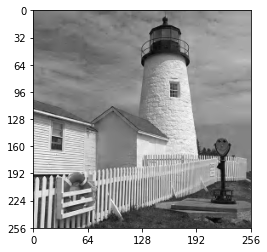

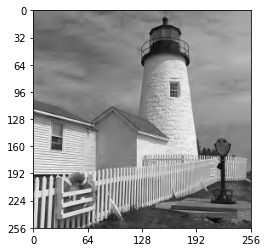

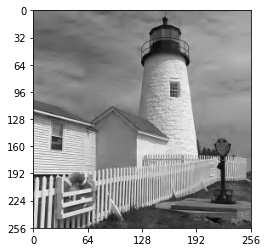

In [24]:
# DWT constant step
from cued_sf2_lab.dwt import dwt, nlevdwt, idwt, nlevidwt, dwtImpulseResponse, dwtQuantMatrix

threshold = np.std(lighthouse-quantise(lighthouse,17))
epsilon = 1
qstep = 100
vals = [[]] * 2

def dwtrms(image, dwtstep, levels, RiseFactor):
    Y = nlevdwt(image, levels)
    Yq = quantdwt(Y, dwtstep, RiseFactor)[0]
    Zq = nlevidwt(Yq, levels)
    """fig,ax = plt.subplots()
    plot_image(Zq,ax=ax)"""
    return np.std(image - Zq)

for i in [3, 4]:
    qstep = 50
    for j in [0.5, 1, 1.5]:
        qstep = 50
        dwtstep = dwtQuantMatrix(qstep, i, EqualStep = True)
        rms = dwtrms(lighthouse, dwtstep, i, j)
        count = 0
        while rms > threshold:
            count += 1
            #if count == 50:
            #    break
            print(count)
            dwtstep1 = dwtQuantMatrix(qstep + epsilon, i, EqualStep = True)
            rms1 = dwtrms(lighthouse, dwtstep1, i, j)

            dwtstep2 = dwtQuantMatrix(qstep - epsilon, i, EqualStep = True)
            rms2 = dwtrms(lighthouse, dwtstep2, i, j)

            if rms1 < rms2:
                rms = rms1
                qstep += epsilon
            elif rms1 > rms2:
                rms = rms2
                qstep -= epsilon
        vals[i-3].append((qstep,rms, j))
        Y = nlevdwt(lighthouse, i)
        dwtstep = dwtQuantMatrix(qstep, i, EqualStep = True)
        Yq = quantdwt(Y, dwtstep, j)[0]
        Zq = nlevidwt(Yq, i)
        fig,ax = plt.subplots()
        plot_image(Zq,ax=ax)
        print(qstep, rms)

In [25]:
vals0 = vals[0]
print(vals0)
bits_reference = bpp(quantise(lighthouse,17))*256*256
c_ratios = []
for i in vals0:
    dwtstep = dwtQuantMatrix(i[0], 3, EqualStep = True)
    Y = nlevdwt(lighthouse, 3)
    Yq = quantdwt(Y, dwtstep, i[-1])[0]
    bits_scheme = 0
    for u in quantdwt(Y,dwtstep, i[-1])[1]:
        for j in u:
    
            bits_scheme+=j
            
    bits_scheme+= quantdwt(Y,dwtstep, i[-1])[3]
    bits = quantdwt(Y, dwtstep, i[-1])[1]
    print(bits_reference/bits_scheme)
    #c_ratios.append()

[(6, 4.498324079711892, 0.5), (4, 4.481941423188501, 1), (3, 4.689167075209895, 1.5)]
19.819852164300173
20.322191063546722
20.04280985067058


Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>